<head>
    <style>
        .md-typeset h2 {
            margin:0;
            }
        .md-typeset h3 {
            margin:0;
            }
        .jupyter-wrapper table.dataframe tr, .jupyter-wrapper table.dataframe th, .jupyter-wrapper table.dataframe td {
            text-align:left;
            }
        .jupyter-wrapper table.dataframe {
            table-layout: auto;
            }
    </style>
</head>

# 5 Basis Expansions and Regularization

## 5.1 Introduction 

Linear regression, LDA, logistic regression and separating hyper planes all rely on a linear model. It is extremely unlikely that the true function $f(X)$ is actually linear in $X$. In regression problems, $f(X) = \text{E}(Y|X)$ will typically be nonlinear and non-additive in $X$.

Representing $f(X)$ by a linear model is usually a convenient, and sometimes necessary, approximation.
* Convenient because a linear model is easy to interpret, and is the first-order Taylor approximation to $f(X)$.
* Sometimes necessary because with $N$ small and/or $p$ large, a linear model might be all we are able to fit to the data without over-fitting.

Likewise in classification, a linear, Bayes-optimal decision boundary implies that some monotone transformation of $\text{Pr}(Y=1|X)$ is linear in $X$. This is inevitably an approximation.


The core idea in this chapter is to augment/replace the vector of inputs $X$ with additional variables, which are transformatons of $X$, and then use linear models in this new space of derived input features.

Denote by

\begin{equation}
h_m(X): \mathbb{R}^p \mapsto \mathbb{R}
\end{equation}

the $m$th transformation of $X$ for $m=1,\cdots,M$. We then model

\begin{equation}
f(X) = \sum_{m=1}^M \beta_m h_m(X),
\end{equation}

_a linear basis expansion_ in $X$.

The beauty of this approach is that once the basis functions $h_m$ have been determined, the models are linear in these new variables, and the fitting proceeds as before.


Some simple and widely used examples of the $h_m$ are the following.

* $h_m(X)=X_m$, $m=1,\cdots,p$ recovers the original linear model.
* $h_m(X)=X_j^2$ or $h_m(X)=X_j X_k$ allows us to augment the inputs with polynomial terms to achieve higher-order Taylor expansions.  
Note, however, that the number of variables grows exponentially in the degrees of the polynomial. A full quadratic model in $p$ variables requires $O(p^2)$ square and corss-product terms, or more generally $O(p^d)$ for a degree-$d$ polynomial.
* $h_m(X)=\log(X_j)$, $\sqrt{X_j}$, $\cdots$ permits other nonlinear transformations of single inputs. More generally one can use similar functions involving several inputs, such as $h_m(X)=\|X\|$.
* $h_m(X)=I(L_m \le X_k \lt U_m)$, an indicator for a region of $X_k$. By breaking the range of $X_k$ up into $M_k$ such nonoverlapping regions results in a model with a piecewise constant contribution for $X_k$.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

### Polynomial regression

For a standard linear model, we could extend it as a polynomial function:

$$y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta_3 x_i^3 + \cdots + \epsilon_i$$

In [2]:
# fit with wage and age
wage = pd.read_csv('./data/Wage.csv')
wage.head()

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [3]:
# get x and y
wage_x = wage['age'].values  # shape (3000, 0)
wage_y = wage['wage'].values.reshape(-1, 1)

# utility function
def _poly(x, degree=4):
    """degree = 4"""
    x = x.reshape(-1, 1)
    xconst = np.ones_like(x)
    x2 = np.power(x, 2)
    x3 = np.power(x, 3)
    if degree == 3:
        return np.hstack([xconst, x, x2, x3])
    x4 = np.power(x, 4)

    return np.hstack([xconst, x, x2, x3, x4])

def _estimate_beta(x, y):
    """
    x: n by m matrix
    y: n by 1 vector
    return m by 1 vector
    """
    y = y.reshape(-1, 1)
    beta = np.linalg.solve(x.T @ x, x.T @ y)
    yhat = x @ beta

    return beta, yhat

# construct the polynomial basis 
wage_poly = _poly(wage_x)
# fit the model 
beta_hat, yhat = _estimate_beta(wage_poly, wage_y)
# estimate variance 
residual = wage_y - yhat

# variance 
sigma_hat = (residual.T @ residual) / (wage_x.shape[0] - 5)  # n-k 

sigma_hat

array([[1593.19006639]])

In [4]:
# calcuate variance and covariance matrix for beta
beta_hat_cov = sigma_hat * np.linalg.inv(wage_poly.T @ wage_poly)
beta_hat_cov.shape

(5, 5)

We know $Y = X \beta$, once we have covariance matrix for $\beta$, then we could
estimate variance for $Y$. With the follow formula:

$$X cov(\beta) X'$$

In [5]:
yhat_pointwise_variance = np.diagonal(wage_poly @ beta_hat_cov @ wage_poly.T)
yhat_pointwise_variance.shape

(3000,)

We can construct the confidence interval wit the formula:

$$\hat{y} \pm 1.95 \times SE$$

In [6]:
# confidence interval 
yhat_plus = yhat.ravel() + 1.95 * np.sqrt(yhat_pointwise_variance)
yhat_minus = yhat.ravel() - 1.95 * np.sqrt(yhat_pointwise_variance)

In [7]:
print(yhat.shape, yhat_plus)

(3000, 1) [ 62.26307342  88.03682397 121.48605649 ...  98.39917297  98.39917297
 121.15529124]


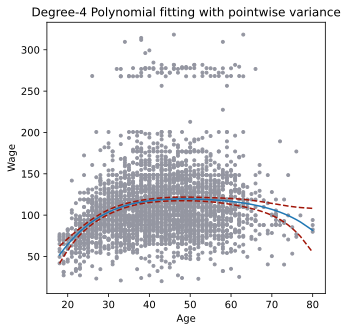

In [8]:
# plot the estimation
sorted_idx = np.argsort(wage_x)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(wage_x, wage_y, 'o', color='#9496A1', markersize=3)
ax.plot(wage_x[sorted_idx], yhat[sorted_idx])
ax.plot(
    wage_x[sorted_idx], yhat_plus[sorted_idx], linestyle='dashed',
    color='#a11508'
    )
ax.plot(
    wage_x[sorted_idx], yhat_minus[sorted_idx], linestyle='dashed',
    color='#a11508'
    )
ax.set_xlabel('Age')
ax.set_ylabel('Wage')
ax.set_title('Degree-4 Polynomial fitting with pointwise variance');

## 5.2 Piecewise Polynomials and Splines

> We assume until $\S$ 5.7 that $X$ is one-dimensional.

A piecewise polynomial function $f(X)$ is obtained by dividing the domain of $X$ into contiguous intervals and representing $f$ by a separate polynomial in each interval. FIGURE 5.1 shows two simple piecewise polynomials. The first is piecewise constant, with three basis functions:

\begin{equation}
h_1(X) = I(X \lt \xi_1), \\
h_2(X) = I(\xi_1 \le X \lt \xi_2), \\
h_3(X) = I(\xi_2 \le X \lt \xi_3). \\
\end{equation}

Since these are positive over disjoint regions, the least squares estimate of the model

\begin{equation}
f(X) = \sum_{m=1}^3 \beta_m h_m(X)
\end{equation}

amounts to $\hat\beta_m = \bar{Y}_m$, the mean of $Y$ in the $m$th region.

In [9]:
# generate dataset
x0, x1, x2, x3 = -1.5, 1.5, 4.5, 7.5
xgrid = np.linspace(x0, x3, 100)
ygrid = np.cos(xgrid) + 2

# generate sample with gaussian noise 
np.random.seed(187)
sample_n = 60
sample_x = np.linspace(x0, x3, sample_n)
sample_y = np.cos(sample_x) + np.random.normal(0, 0.5, sample_n) + 2

# piecewise constant
x_seg1 = sample_x[sample_x < x1]
x_seg2 = sample_x[(sample_x >= x1) & (sample_x < x2)]
x_seg3 = sample_x[sample_x >= x2]
y_seg1 = sample_y[sample_x < x1]
y_seg2 = sample_y[(sample_x >= x1) & (sample_x < x2)]
y_seg3 = sample_y[sample_x >= x2]

Since we have assumed that $X$ is one-dimensional (this means only one variable).
The only way we could expand the basis is to transer $X$ itself, such as
$\phi(x) = [1, x, x^2]$.

We could also transfer $X$ as:

$$h_1(X) = 1, h_2(X) = X, h_3(X) = (X- \xi_1), h_4(X) = (X-\xi_2)$$

In [10]:
X = np.copy(sample_x.reshape(-1, 1))
h1 = np.ones_like(X)
h3 = np.where(X < x1, 0, X-x1)  # similar to ReLU function
h4 = np.where(X < x2, 0, X-x2)
H = np.hstack([h1, X, h3, h4])
H.shape

(60, 4)

In [11]:
beta = np.linalg.solve(H.T @ H, H.T @ sample_y.reshape(-1, 1))
y_hat = H @ beta

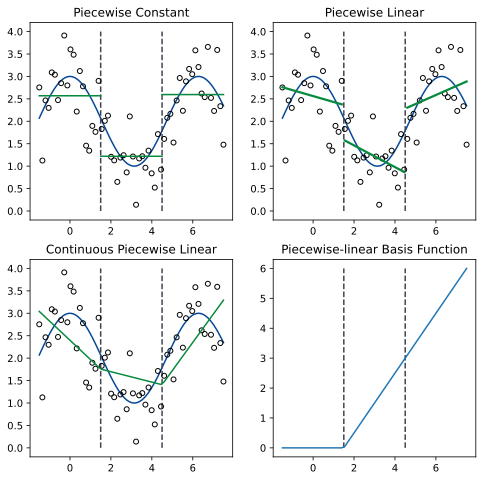

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    if i <= 2:
        ax.plot(xgrid, ygrid, color='#064894')
        ax.plot([x1, x1], [0, 4], '--', color="#404352")
        ax.plot([x2, x2], [0, 4], '--', color="#404352")
        ax.plot(sample_x, sample_y, 'ok',
            fillstyle="none", markersize=5)
    else:
        ax.plot([x1, x1], [0, 6], '--', color="#404352")
        ax.plot([x2, x2], [0, 6], '--', color="#404352")

axes[0, 0].plot([x0, x1], 
                [np.mean(y_seg1), np.mean(y_seg1)],
                color='#088a3e')
axes[0, 0].plot([x1, x2], 
                [np.mean(y_seg2), np.mean(y_seg2)],
                color="#088a3e")
axes[0, 0].plot([x2, x3], 
                [np.mean(y_seg3), np.mean(y_seg3)],
                color="#088a3e")
axes[0, 0].set_title('Piecewise Constant')
sns.regplot(x=x_seg1, y=y_seg1, ax=axes[0, 1], 
            ci=None, scatter=False, color='#088a3e')
sns.regplot(x=x_seg2, y=y_seg2, ax=axes[0, 1], 
            ci=None, scatter=False, color='#088a3e')
sns.regplot(x=x_seg3, y=y_seg3, ax=axes[0, 1], 
            ci=None, scatter=False, color='#088a3e')
axes[0, 1].set_title('Piecewise Linear')
axes[1, 0].plot(sample_x, y_hat, color='#088a3e')
axes[1, 0].set_title('Continuous Piecewise Linear')
axes[1, 1].plot(sample_x, h3)
axes[1, 1].set_title('Piecewise-linear Basis Function'); 

Before we continue to discuss _splines_, let's summarize what we have done. We
assume $X$ is one-dimensional, and constructed:

- _piecewise constant_ with basis function like $h_1(X) = I(X < \xi_1)$
- _piecewise linear_ with breaks
- _piecewise linear_ with continuous restrictions at the two knots 

When we add $h_3(X) = (X-\xi_1)_+$ we incorporates the constraints, which
makes the fitted curve are continuous at $\xi_1$. 

For smoother functions, the order of the local polynomial increases. FIGURE 5.2 shows a series of piecewise-cubic polynomials fit to the same data, with increasing orders of continuity at the knots. A _cubic spline_ in the lower right panel is continuous, and has continuous first and second derivatives at the knots. Enforcing one more order of continuity would lead to a global cubic polynomial.

It is not hard to show (Exercise 5.1) that the following basis represents a cubic spline with knots at $\xi_1$ and $\xi_2$:

\begin{aligned}
h_1(X) &= 1, \\
h_2(X) &= X, \\
h_3(X) &= X^2, \\
h_4(X) &= X^3, \\
h_5(X) &= (X-\xi_1)_+^3, \\
h_6(X) &= (X-\xi_2)_+^3.
\end{aligned}

There are six basis functions corresponding to a six-dimensional linear space of functions. A quick check confirms the parameter count:

$$
3\text{ regions } \times 4\text{ paramters per region } - 2\text{ knots } \times 3\text{ constraints per knot } = 6.
$$ 

We have _three constraints_ because it has to be continuous, and to have
continuous first and second derivatives. 

### Polynomial interpolation

![interpolants](https://miro.medium.com/max/720/1*uHTzg3XPt3L_gX3--V7u2w.png)

Given some points $(x_0, y_0), (x_1, y_1), \cdots, (x_n, y_n)$ we want to find
a polynomial function that passes through all of them. Now, consider the points:

$$C = \{ (2, 2), (3, 6), (4, 5), (5, 5), (6, 6) \}$$

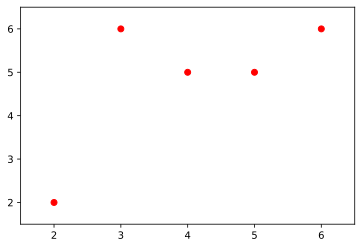

In [13]:
# an example
x = np.array([2, 3, 4, 5, 6])
y = np.array([2, 6, 5, 5, 6])
plt.plot(x, y, 'ro')
plt.axis([1.5, 6.5, 1.5, 6.5]);

In [14]:
# vandermonde's matrix
x_const = np.ones_like(x)
vander_mat = np.vstack(
    [x_const, x, np.power(x, 2), np.power(x, 3), np.power(x, 4)]).T
coef = np.linalg.solve(
    vander_mat.T @ vander_mat, vander_mat.T @ y.reshape(-1, 1)
    )
coef

array([[-75.        ],
       [ 81.00000001],
       [-29.25      ],
       [  4.5       ],
       [ -0.25      ]])

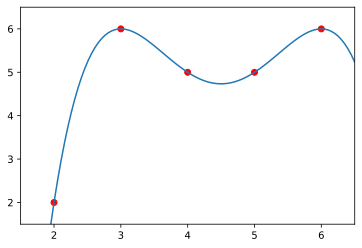

In [15]:
foox = np.linspace(1.5, 6.5, 100)
foo_mat = np.vstack(
    [np.ones_like(foox), foox, np.power(foox, 2), 
    np.power(foox, 3), np.power(foox, 4)]
    ).T
x = np.array([2, 3, 4, 5, 6])
y = np.array([2, 6, 5, 5, 6])
plt.plot(x, y, 'ro')
plt.axis([1.5, 6.5, 1.5, 6.5])
plt.plot(foox, foo_mat @ coef);

### Cubic spline 

In [16]:
def _cubic_basis(x, continuous_degree=3):
    """
    constructut cubic basis for x
        Input: x n by 1 matrix
        output: H n by 4 matrix
    This functions means: 4 parameters per region
                          3 contraints per knot 
    continuous_at = 3, 2, 1, 0 (discontinuous)
    """
    x1, x2 = 1.5, 4.5
    x = x.reshape(-1, 1)
    h1 = np.ones_like(x)
    h2 = np.copy(x)
    h3 = np.power(x, 2)
    h4 = np.power(x, 3)

    if continuous_degree == 3:
        h5 = np.power(np.where(X<x1, 0, X-x1), 3)
        h6 = np.power(np.where(X<x2, 0, X-x2), 3)
        return np.hstack([h1, h2, h3, h4, h5, h6])
    elif continuous_degree == 2:
        h5 = np.power(np.where(X<x1, 0, X-x1), 2)
        h6 = np.power(np.where(X<x2, 0, X-x2), 2)
        return np.hstack([h1, h2, h3, h4, h5, h6])
    elif continuous_degree == 1:
        h5 = np.power(np.where(X<x1, 0, X-x1), 1)
        h6 = np.power(np.where(X<x2, 0, X-x2), 1)
        return np.hstack([h1, h2, h3, h4, h5, h6])
    else:
        return np.hstack([h1, h2, h3, h4])

In [17]:
def _estimate_beta(x, y):
    """
    x: n by m matrix
    y: n by 1 vector
    return m by 1 vector
    """
    y = y.reshape(-1, 1)
    beta = np.linalg.solve(x.T @ x, x.T @ y)
    yhat = x @ beta

    return beta, yhat 


A piecewise cubic polynomial function with three constraints(continuity, continuity of the first and second derivative) is called as cubic spline. The degree of freedom of cubic spline is $K+4$, where $K$ is the number of knots. It can be explained as: The left(or right) end of the polynomial has a degree of freedom 4(as we have to estimate 4 coefficients or parameters to fit a cubic spline).

Each additional knot adds one parameter (as three imposed constraints leave one free parameter) and hence making a total of $K+4$ parameters for $K$ knots. In general, a degree-d spline is a piecewise degree-d polynomial with continuity in derivatives upto degree $d−1$ at each knot.

\begin{equation*}
h(x, \xi) = (x - \xi)^3 _+ = \{
\begin{array}{}
(x - \xi)^3, & \text{if}\ x > \xi; & \
0, & \text{otherwise}
\end{array}\}.
\end{equation*}

It is important to notice that at each know $\xi$, we have:

\begin{aligned}
h' & = h' \\
h'' & = h''
\end{aligned}

In [18]:
# figure 5.2 
# dictontinuous (estimate beta for each region)
cubic_seg1 = _cubic_basis(x_seg1, continuous_degree=0)
_, yhat_seg1 = _estimate_beta(cubic_seg1, y_seg1)
_, yhat_seg2 = _estimate_beta(
    _cubic_basis(x_seg2, 0), y_seg2
)
_, yhat_seg3 = _estimate_beta(
    _cubic_basis(x_seg3, 0), y_seg3
)

In [19]:
# continuous
c1 = _cubic_basis(sample_x, 1)
beta1, yhat1 = _estimate_beta(c1, sample_y)
c2 = _cubic_basis(sample_x, 2)
beta2, yhat2 = _estimate_beta(c2, sample_y)
c3 = _cubic_basis(sample_x, 3)
beta3, yhat3 = _estimate_beta(c3, sample_y)

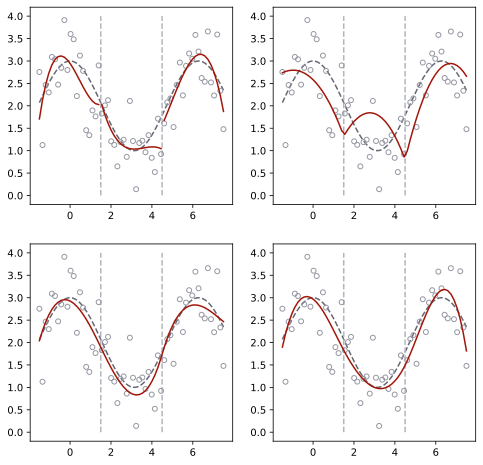

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.plot(xgrid, ygrid, color='#656673', linestyle='--')
    ax.plot([x1, x1], [0, 4], '--', color="#B3B5BD")
    ax.plot([x2, x2], [0, 4], '--', color="#B3B5BD")
    ax.plot(sample_x, sample_y, 'o', color='#9496A1',
        fillstyle="none", markersize=5)

axes[0, 0].plot(x_seg1, yhat_seg1, color='#a11508')
axes[0, 0].plot(x_seg2, yhat_seg2, color='#a11508')
axes[0, 0].plot(x_seg3, yhat_seg3, color='#a11508')
axes[0, 1].plot(sample_x, yhat1, color='#a11508')
axes[1, 0].plot(sample_x, yhat2, color='#a11508')
axes[1, 1].plot(sample_x, yhat3, color='#a11508');

More generally, an order-$M$ spline with knots $\xi_j$, $j = 1,\cdots,K$ is a piecewise-polynomial of order M, and has continuous derivatives up to order $M-2$. A cubic spline has $M = 4$. In fact the piecewise-constant function in FIGURE 5.1 is an order-1 spline. Likewise the general form for the truncated-power basis set would be

\begin{aligned}
h_j(X) &= X^{j-1}, &\text{for } j = 1,\cdots,M, \\
h_{M+l}(X) &= (X-\xi_l)_+^{M-1}, &\text{for } l = 1,\cdots,K.
\end{aligned}

It is claimed that cubic splines are the lowest-order spline for which the
knot-discontinuity is not visible to the human eye. There is seldom any
good reason to go beyond cubic-splines, unless one is interested in smooth
derivatives. In practice the most widely used orders are M = 1, 2 and 4.

###  Natural cubic splines

We know that the behavior of polynomials fit to data tends to be erratic
near the boundaries, and extrapolation can be dangerous. These problems
are exacerbated with splines. The polynomials fit beyond the boundary
knots behave even more wildly than the corresponding global polynomials
in that region. This can be conveniently summarized in terms of the pointwise variance of spline functions fit by least squares. 

A natural cubic spline adds additional constraints, namely that the function is linear beyond the boundary knots. This frees up four degrees of
freedom (two constraints each in both boundary regions), which can be
spent more profitably by sprinkling more knots in the interior region.

A natural cubic splines with $K$ knots is represented by $K$ basis functions. One can start from a basis for cubic splines, and then derive the reduced basis by imposing the boundary constraints.

The basis follows the following construction rules:

\begin{aligned}
N_1(X) &= 1, \\
N_2(X) &= X, \\
N_{k+2}(X) &= d_k(X) - d_{K-1}(X),
\end{aligned}

where

$$
d_k(X) = \frac{(X-\xi_k)_+^3 - (X-\xi_K)_+^3}{\xi_K-\xi_k}.
$$

In [21]:
np.array([.1, .26, .42, .58, .74, .9])*8-1

array([-0.2 ,  1.08,  2.36,  3.64,  4.92,  6.2 ])

In [22]:
# define natrual spline construction
def _natural_cubic_util(x, x_knots, k:int):
    x = x.reshape(-1, 1)
    num1 = np.where(x < x_knots[k], 0, (x-x_knots[k])**3)
    # last knot 
    num2 = np.where(x < x_knots[-1], 0, (x-x_knots[k])**3)
    denom = x_knots[-1] - x_knots[k]

    return (num1-num2)/denom 

In [24]:
# figure 5.3
np.random.seed(789)
sample_x = np.random.uniform(0, 1, 50)
# assumed error model with constant variance 
sample_y = 3*sample_x + np.random.normal(0, 1, 50)

In [25]:
def _construct_basis(x):
    """
    linear 
    global cubic polynomial
    global cubic spline with 2 knots
    natural cubic spline with 6 knots
    """
    x = x.reshape(-1, 1)
    const = np.ones_like(x)
    
    linear = np.hstack([const, x])
    p2 = np.power(x, 2)
    p3 = np.power(x, 3)
    cubic = np.hstack([const, x, p2, p3])
    # 2 knots 
    cknots0, cknots1 = 0.33, 0.66 
    h5 = np.power(np.where(x<cknots0, 0, x-cknots0), 3)
    h6 = np.power(np.where(x<cknots1, 0, x-cknots1), 3)
    cubic_spline = np.hstack([const, x, p2, p3, h5, h6])
    # 6 knots
    natural_cubic_knots = np.linspace(0.1, 0.9, 6)
    # from degree 3 we use the formula
    d1 = _natural_cubic_util(x, natural_cubic_knots, 0)
    d_k_1 = _natural_cubic_util(x, natural_cubic_knots, -2)
    h3 = d1 - d_k_1
    d2 = _natural_cubic_util(x, natural_cubic_knots, 1)
    h4 = d2 - d_k_1
    d3 = _natural_cubic_util(x, natural_cubic_knots, 2)
    h5 = d3 - d_k_1
    d4 = _natural_cubic_util(x, natural_cubic_knots, 3)
    h6 = d4 - d_k_1
    natural_cubic = np.hstack([const, x, h3, h4, h5, h6])
    
    return linear, cubic, cubic_spline, natural_cubic
    

In [26]:

linear, cubic, cubic_spline, natural_cubic = _construct_basis(sample_x)
x_basis = {
    'Global Linear': linear,
    'Global Cubic Polynomial': cubic,
    'Cubic Spline - 2 knots': cubic_spline,
    'Natural Cubic Spline - 6 knots': natural_cubic
}
# estimate the model
pointwise_variace = {
    'Global Linear': [],
    'Global Cubic Polynomial': [],
    'Cubic Spline - 2 knots': [],
    'Natural Cubic Spline - 6 knots': []
}
sample_y = sample_y.reshape(-1,1 )
for model, data in x_basis.items():
    # estimate beta
    beta, yhat = _estimate_beta(data, sample_y.reshape(-1, 1))
    # estimate variance 
    residual = sample_y - yhat
    # variance / n-k 
    sigma_hat = (residual.T @ residual) / (data.shape[0] - data.shape[1]) 
    # calcualte variance and covariance matrix for beta
    beta_hat_cov = sigma_hat * np.linalg.inv(data.T @ data)
    beta_hat_cov.shape
    variance = np.diagonal(data @ beta_hat_cov @ data.T)
    pointwise_variace[model] = variance

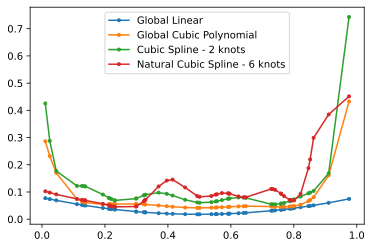

In [27]:
sorted_idx = np.argsort(sample_x)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for model, data in pointwise_variace.items():
    ax.plot(
        sample_x[sorted_idx], data[sorted_idx], 'o-',
        markersize=3, label=model
    )
ax.legend(loc='upper center');

Figure 5.3 compares the point-wise variances for a variety of different models. 
The explosion of the variance near the boundaries is clear, and inevitably 
is worst for cubic splines.

A _natural cubic spline_ adds additional constraints, namely that the 
function is linear beyond the boundary knots. This frees up four degrees 
of freedom (two constraints each in both boundary regions), which can 
be spent more profitably by sprinkling more knots in the interior region. 
This tradeoff is illustrated in terms of variance in Figure 5.3.

### Example: South African heart disease (continued)

In [2]:
# read heart disease data 
sa_heart = pd.read_csv('./data/heart/SAheart.data', index_col=0)
sa_heart.head()

sa_heart['famhist'] = pd.get_dummies(sa_heart['famhist'])['Present']
target = 'chd'
features = ['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'alcohol', 'age']
sa_heart[features + [target]].head()

,sbp,tobacco,ldl,famhist,obesity,alcohol,age,chd
row.names,,,,,,,,
1,160,12.00,5.73,1,25.30,97.20,52,1
2,144,0.01,4.41,0,28.87,2.06,63,1
3,118,0.08,3.48,1,29.14,3.81,46,0
4,170,7.50,6.41,1,31.99,24.26,58,1
5,134,13.60,3.50,1,25.99,57.34,49,1


Since in last chapter, we have already implement logistic regression on our own,
we will just use API from `statsmodels`. 

In [10]:
import statsmodels.api as sm
from scipy import stats
# convert data to X, y np.arrays
X, y = sa_heart[features].values, sa_heart[target].values

lr = sm.Logit(y, sm.add_constant(X)).fit(disp=False)

result = zip(['(Intercept)'] + features, lr.params, lr.bse, lr.tvalues)
print('               Coefficient   Std. Error   Z Score')
print('-------------------------------------------------')
for term, coefficient, std_err, z_score in result:
    print(f'{term:>12}{coefficient:>14.3f}{std_err:>13.3f}{z_score:>10.3f}')

               Coefficient   Std. Error   Z Score
-------------------------------------------------
 (Intercept)        -4.130        0.964    -4.283
         sbp         0.006        0.006     1.023
     tobacco         0.080        0.026     3.034
         ldl         0.185        0.057     3.218
     famhist         0.939        0.225     4.177
     obesity        -0.035        0.029    -1.187
     alcohol         0.001        0.004     0.136
         age         0.043        0.010     4.181


At this stage the analyst might do some model selection; find a subset of 
the variables that are sufficient for explaining their joint effect on the 
prevalence of chd. One way to proceed by is to drop the least significant 
coefficient, and refit the model. This is done repeatedly until no 
further terms can be dropped from the model. This gave the model shown in Table 4.3.

A better but more time-consuming strategy is to refit each of the models 
with one variable removed, and then perform an analysis of deviance to 
decide which variable to exclude. The residual deviance of a fitted model 
is minus twice its log-likelihood, and the deviance between two models is 
the difference of their individual residual deviances 
(in analogy to sums-of- squares).

### Likelihood ratio test

The likelihood ratio (LR) test has the generic notation:

$$LR = -2[\ln(f(\hat{\theta_R})) - \ln(f(\hat{\theta}))]$$

With the Taylor series expansion, one could show this ratio follows the 
chi-squared distribution with degree of freedom equals to the differences 
of parameters from two models. Read [this](https://en.wikipedia.org/wiki/Wilks%27_theorem)
to learn more about this test. 

In [9]:
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression

In [72]:
# calculates total deviance of a model on a data set
def deviance(X, y, model):
    return 2*log_loss(y, model.predict_proba(X), normalize=False)


# calculates total deviance of a model trained on features subset
def subset_deviance(model, selected_ids):
    X_selected = X[:, sorted(list(selected_ids))]
    model.fit(X_selected, y)
    return deviance(X_selected, y, model)


lr = LogisticRegression(solver='lbfgs', max_iter=100000, C=10e10)
# start with all features selected, store features indices
selected_ids = set(range(len(features)))
current_deviance = subset_deviance(lr, selected_ids)

current_k = len(selected_ids)
while True:
    # what would be the total deviance if we remove a feature?
    deviances = [
        (subset_deviance(lr, selected_ids - set([idx])), idx)
        for idx in selected_ids]
    # find a feature to remove to minimize resulting total deviance
    min_deviance, feature_to_remove_idx = min(deviances)
    # the difference between the deviances for the two models follows
    # an approximate chi-squared distribution. Use it for stopping criteria.
    deviance_diff = min_deviance - current_deviance
    df_k = current_k - 1 
    p_value = 1 - stats.chi2.cdf(deviance_diff, df=df_k)
    if p_value < 0.05:
        break
    selected_ids -= set([feature_to_remove_idx])
    current_k = len(selected_ids)
    current_deviance = min_deviance
    print(f'REMOVE: {features[feature_to_remove_idx]}')

# selected feature names
selected_ids = sorted(list(selected_ids))
features_selected = [features[i] for i in selected_ids]

REMOVE: alcohol
REMOVE: sbp
REMOVE: obesity


In [32]:
# PAGE 124. TABLE 4.3. Results from stepwise logistic regression fit to South
#           African heart disease data.
lr = sm.Logit(y, sm.add_constant(X[:, selected_ids])).fit(disp=False)
result = zip(['(Intercept)']+features_selected, lr.params, lr.bse, lr.tvalues)
print('               Coefficient   Std. Error   Z Score')
print('-------------------------------------------------')
for term, coefficient, std_err, z_score in result:
    print(f'{term:>12}{coefficient:>14.3f}{std_err:>13.3f}{z_score:>10.2f}')

               Coefficient   Std. Error   Z Score
-------------------------------------------------
 (Intercept)        -4.204        0.498     -8.44
     tobacco         0.081        0.026      3.16
         ldl         0.168        0.054      3.09
     famhist         0.924        0.223      4.14
         age         0.044        0.010      4.52


### L1 regularized logistic regression

Suppose we are dealing with _negative log-likelihood function (NLL)_, then we have
the following gradient and Hessian matrix:

\begin{aligned}
g(\theta) & = X'(p-y) \\
H(\theta) & = X'S X \\
S(\theta) & = \text{diag}(p(1-p))
\end{aligned}

Where $p, y$ are $n \times  1$ column vector, $X$ is an $n \times m$ matrix, 
and $S$ is an $n \times n$ matrix. The updating rule is

$$\theta_{t+1} = \theta_t - H^{-1} g_t$$

This gives:

\begin{aligned}
\theta_{t+1} & = \theta_t - (X'S X)^{-1} X'(p-y) \\
             & = \theta_t + (X'S X)^{-1} X'(y-p) \tag{sign changed}
\end{aligned}

It's important to know that Iterated Reweighted Least Squares (IRLS) is just
a special case of Netwon's method:

\begin{aligned}
\theta_{t+1} & = \theta_t - H^{-1} g_t \\
\theta_{t+1} & = \theta_t + (X'SX)^{-1}X'(y-p) \\
             & = (X'S_tX)^{-1}X'S_t z_t \\
z_t & = X \theta_t + S_t^{-1}(y-p)
\end{aligned}

In [67]:
import cvxpy as cp
from sklearn.preprocessing import StandardScaler
def sigmoid(x):
    # sigmoid function
    return 1/(1+np.exp(-x))

In [89]:
# logistic regression wit Iterated Reweighted Least Squares
# IRLS 

def logistic_irls(X, y, standardization=False, 
                            regularion=None, regu_lambda = None, 
                            epsilon=1e-12, 
                                             iter=500):
    """
    logistic regression with IRLS algorithm
    X: n by m matrix without constants
    y: n by 1 vector
    """
    n, m = X.shape
    if standardization:
        X = StandardScaler().fit_transform(X)
    
    const = np.ones([n, 1])
    X = np.hstack([const, X])

    # initialize beta
    beta0 = np.zeros([m+1, 1]) 
    delta = 1
    iteration = 0
    neg_log_likelihood = []

    if regularion is None:
        while delta > epsilon and iteration < iter:
            iteration += 1 
            w = X @ beta0  # n by 1 matrix 
            phat = sigmoid(w) # n by 1 
            # calculate neg log-likelihood 
            ratio1 = y.T @ np.log(phat) 
            ratio2 = (1-y).T @ np.log((1- phat))
            nll = -(ratio1+ratio2)
            neg_log_likelihood.append(nll)
            
            s = phat * (1 - phat)  # n by n 
            ##----------! Very important step ----
            s = s.flatten()
            ##----------! Very important step ----
            S = np.diag(s) # diagonal matrix 
            z = w + np.linalg.inv(S) @ (y-phat)
            # use IRLS formula to update beta
            beta0 = np.linalg.inv(X.T @ S @ X) @ X.T @ S @ z
            # calculate nll again 
            phat = sigmoid(X @ beta0)
            # calculate neg log-likelihood 
            nll_new = -(y.T @ np.log(phat) + (1-y).T @ np.log(1- phat))
            delta = np.abs(nll_new - nll)
    elif regularion == 'L1':
        # using newton methods 
        while delta > epsilon and iteration < iter:
            iteration += 1 
            w = X @ beta0  # n by 1 matrix 
            phat = sigmoid(w)  # n by 1 
            # calculate neg log-likelihood 
            ratio1 = y.T @ np.log(phat) 
            ratio2 = (1-y).T @ np.log((1- phat))
            nll = -(ratio1+ratio2)
            neg_log_likelihood.append(nll)
            
            s = phat * (1 - phat)  # n by n 
            ##----------! Very important step ----
            s = s.flatten()
            ##----------! Very important step ----
            S = np.diag(s) # diagonal matrix 
            # L1 regularization no penalty for intercept 
            intercept = beta0[0, 0]
            intercept = intercept.reshape(1, 1)
            beta_coefs = beta0[1:, 0]
            beta_coefs = beta_coefs.reshape(-1, 1)
            # gradient for intercept 
            g0 = X[:, 0].T @ (phat - y)  # 1 by n times n by 1 
            # gradient for others
            g1 = X[:, 1:].T @ (phat - y) + regu_lambda * np.sign(beta_coefs) 
            # hessian matrix (positive version for negative LogL)
            H0 = X[:, 0].T @ S @ X[:, 0]
            H0 = H0.reshape(1, 1)
            H1 = X[:, 1:].T @ S @ X[:, 1:]
            # update intercept
            intercept = intercept - np.linalg.inv(H0) @ g0
            # update other coefficients
            beta_coefs = beta_coefs - np.linalg.inv(H1) @ g1
            # combine beta
            beta0 = np.vstack([intercept, beta_coefs])
            # calculate nll again 
            phat = sigmoid(X @ beta0)
            # calculate neg log-likelihood 
            nll_new = -(y.T @ np.log(phat) + (1-y).T @ np.log(1- phat))
            delta = np.abs(nll_new - nll)
    elif regularion == 'L1_truncate':
        while delta > epsilon and iteration < iter:
            iteration += 1 
            w = X @ beta0  # n by 1 matrix 
            phat = sigmoid(w)  # n by 1 
            # calculate neg log-likelihood 
            ratio1 = y.T @ np.log(phat) 
            ratio2 = (1-y).T @ np.log((1- phat))
            nll = -(ratio1+ratio2)
            neg_log_likelihood.append(nll)
            
            s = phat * (1 - phat)  # n by n 
            ##----------! Very important step ----
            s = s.flatten()
            ##----------! Very important step ----
            S = np.diag(s) # diagonal matrix 
            # L1 truncate
            # gradient
            g = X.T @ (phat - y)
            # hessian matrix (positive version for negative LogL)
            H = X.T @ S @ X
            # update beta
            beta0 = beta0 - np.linalg.inv(H) @ g
            # truncate coefficients 
            intercept = beta0[0, 0]
            intercept = intercept.reshape(1, 1)
            beta_coefs = beta0[1:, 0]
            beta_coefs = beta_coefs.reshape(-1, 1)
            beta_coefs_list = []
            for c in np.nditer(beta_coefs):
                if c > 0:
                    penalty = c - regu_lambda/n
                    beta_coefs_list.append(max(0, penalty))
                elif c < 0:
                    penalty = c + regu_lambda/n
                    beta_coefs_list.append(min(0, penalty))
                else:
                    beta_coefs_list.append(c)
            beta_coefs = np.array(beta_coefs_list).reshape(-1, 1)
            # combine beta
            beta0 = np.vstack([intercept, beta_coefs])
            # calculate nll again 
            phat = sigmoid(X @ beta0)
            # calculate neg log-likelihood 
            nll_new = -(y.T @ np.log(phat) + (1-y).T @ np.log(1- phat))
            delta = np.abs(nll_new - nll)
    else:
        # using cvxpy optimization 
        # initialize beta 
        beta_cv = cp.Variable(m+1)  
        print(beta_cv.shape)
        # initialize lambda 
        lambd = cp.Parameter(nonneg=True)
        lambd.value = regu_lambda/n
        log_likelihood = cp.sum(
            cp.multiply(y, X @ beta_cv) - cp.logistic(X @ beta_cv)
            )
        problem = cp.Problem(
            cp.Maximize(
                log_likelihood/n - lambd * cp.norm(beta_cv, 1)
                )
            )
        # cvxpy will solve it by maximize the log-likelihood 
        problem.solve()
        beta0 = beta_cv.value 
        w = X @ beta0  # n by 1 matrix 
        phat = sigmoid(w)  # n by 1 
        s = phat * (1 - phat)  # n by n
        S = np.diag(s) # diagonal matrix
        
    # hessian matrix (positive version as we are dealing with 
    # negative log-likelihood)
    H = X.T @ S @ X 
    std_err = np.sqrt(np.diag(np.linalg.inv(H)))

    return beta0, std_err

In [35]:
beta, std_err = logistic_irls(
    X[:, selected_ids],
    y.reshape(-1, 1)
)

In [36]:
table_term = ['intercept'] + list(sa_heart.columns[selected_ids])
for term, coeff, ste in zip(table_term, beta, std_err):
    print('{0:>15} {1:>15.3f} {2:>15.3f} {3:>15.3f}'.format(
        term, float(coeff), float(ste),
        float(coeff)/float(ste)
        ))

      intercept          -4.204           0.498          -8.436
        tobacco           0.081           0.026           3.163
            ldl           0.168           0.054           3.093
      adiposity           0.924           0.223           4.141
        obesity           0.044           0.010           4.520


Now, we will implement IRLS for L1 regulation. When we add the penalty, we have
a different likelihood function:

$$\mathcal{L} = L - \lambda |\theta| $$

The the gradient and Hessian become:

\begin{aligned}
g(\theta) & = X'(p-y) - \lambda \text{sign}(\theta) \\
H(\theta) & = X'S X
\end{aligned}

The updating rule becomes:


\begin{aligned}
\theta_{t+1} & = \theta_t - H^{-1} g_t 
\end{aligned}

We will use newton methods.

This naive method has two serious problems.
The first problem is that, at each update, we need
to perform the application of L1 penalty to all features, including the features
that are not used in
the current training sample. Since the dimension
of the feature space can be very large, it can significantly 
slow down the weight update process.

The second problem is that it does not produce
a compact model, i.e. most of the weights of the
features do not become zero as a result of training. Note that the weight of 
a feature does not become zero unless it happens to fall on zero exactly,
which rarely happens in practice.


> L1 or L2 regularization is equivalent to variable selections

L1 regularization is called lasso lasso regression (Tibshirani, 1996) and 
L2 regularization is called ridge regression. 

L2 regularization is easier to optimize because of its simple derivative while
L1 regularization is more complex (the derivative of $|\theta|$ is non-continuous at zero).
But where L2 prefers weight vectors with many small weights, L1 prefers sparse
solutions with some larger weights but many more weights set to zero. Thus L1
regularization leads to much sparser weight vectors, that is, far fewer features.

In [8]:
from sklearn.preprocessing import StandardScaler

In [38]:
beta, std_err = logistic_irls(
    X,
    y.reshape(-1, 1),
    standardization=True,
    regularion="L1",
    regu_lambda=1.6#0.00557513
)
beta 

array([[-8.31624650e-01],
       [ 1.02936949e-01],
       [ 3.53419806e-01],
       [ 3.55954947e-01],
       [ 4.43921633e-01],
       [-1.08554490e-01],
       [ 7.15952019e-05],
       [ 6.02151906e-01]])

In [39]:
beta, std_err = logistic_irls(
    X,
    y, 
    standardization=True,
    regularion="L1-cvxpy",
    regu_lambda=2 #0.00557513
)
np.round(beta, 7)

(8,)


array([-0.800883 ,  0.0986225,  0.3491127,  0.3478941,  0.4355919,
       -0.0997522,  0.       ,  0.5894775])

In [40]:
lr = sm.Logit(y, sm.add_constant(StandardScaler().fit_transform(X)))
lr.fit_regularized(disp=False, alpha=2).params

array([-0.80086617,  0.09862081,  0.34911403,  0.34786824,  0.43559334,
       -0.09974073,  0.        ,  0.58946533])

In [41]:
lr = sm.Logit(y, sm.add_constant(StandardScaler().fit_transform(X)))
lr.fit_regularized(disp=False, alpha=50).params

array([-0.18672241,  0.        ,  0.01671181,  0.        ,  0.02135875,
        0.        ,  0.        ,  0.27176121])

In [42]:
beta, std_err = logistic_irls(
    X,
    y.reshape(-1, 1),
    standardization=True,
    regularion="L1_truncate",
    regu_lambda=100
)
beta 

array([[-0.78353899],
       [ 0.        ],
       [ 0.1151153 ],
       [ 0.13197057],
       [ 0.20914635],
       [ 0.        ],
       [ 0.        ],
       [ 0.33815325]])

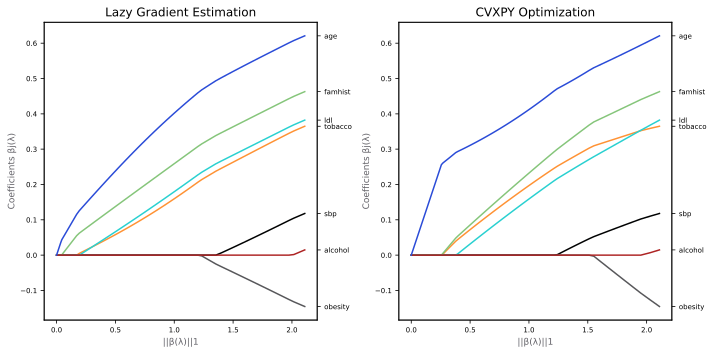

In [59]:
# plot figure 4.13 
GRAY4, GRAY7 = '#646369', '#929497'
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
colors = ['#000101', '#FF9234', '#29D0D0', '#85C57A', '#57575A', '#AD2323',
          '#2A4BD7']
# with lazy gradient estimation 
alpha = np.linspace(0, 300, 100)
coefs = np.ones([1, 7])
for a in alpha:
    beta_tmp, std_err = logistic_irls(
    X,
    y.reshape(-1, 1),
    standardization=True,
    regularion="L1_truncate",
    regu_lambda=a)
    beta_tmp = beta_tmp.reshape(1, -1)
    coefs = np.vstack([coefs, beta_tmp[0, 1:]])

coefs = coefs[1:, :]
# calculate sum of coefficients for different alpha values
coefs_l1_norm = np.sum(np.abs(coefs), axis=1)

for i in range(7):
    axes[0].plot(coefs_l1_norm, coefs[:, i], color=colors[i])

ax2 = axes[0].twinx()
ax2.set_ylim(axes[0].get_ylim())
plt.setp(ax2, yticks=coefs[0], yticklabels=features)
for i in axes[0].get_yticklabels() + axes[0].get_xticklabels() + ax2.get_yticklabels():
    i.set_fontsize(7)
axes[0].set_xlabel('||β(λ)||1', color=GRAY4, fontsize=9)
axes[0].set_ylabel('Coefficients βj(λ)', color=GRAY4, fontsize=9)
axes[0].set_title("Lazy Gradient Estimation")

# with cvxpy optimization
# for different alpha values fit a model and save coefficients
alpha = np.linspace(0, 82, 100)
coefs = np.vstack([lr.fit_regularized(disp=False, alpha=a).params[1:]
                   for a in alpha])
# calculate sum of coefficients for different alpha values
coefs_l1_norm = np.sum(np.abs(coefs), axis=1)

for i in range(7):
    axes[1].plot(coefs_l1_norm, coefs[:, i], color=colors[i])
ax2 = axes[1].twinx()
ax2.set_ylim(axes[1].get_ylim())
plt.setp(ax2, yticks=coefs[0], yticklabels=features)
for i in axes[1].get_yticklabels() + axes[1].get_xticklabels() + ax2.get_yticklabels():
    i.set_fontsize(7)
axes[1].set_xlabel('||β(λ)||1', color=GRAY4, fontsize=9)
axes[1].set_ylabel('Coefficients βj(λ)', color=GRAY4, fontsize=9)
axes[1].set_title("CVXPY Optimization")
fig.tight_layout(pad=1.0);

When we fit a simple model without constructing new basis, we have shown that
the model selection removed the following variables:

- alcohol
- sbp
- obesity

Now, we will fit a new model with the functional form 

$$
\text{logit}\left[ \text{Pr}(\textsf{chd}|X) \right] = \theta_0 + h_1(X_1)^T\theta_1 + h_2(X_2)^T\theta_2 + \cdots + h_p(X_p)^T\theta_p,
$$

where each of the $\theta_j$ are vectors of coefficients multiplying their associated vector of natural spline basis functions $h_j$.

We can combine all $p$ vectors of basis functions (and the constant term) into one big vector $h(X)$, and then the model is simply

$$
h(X)^T\theta,
$$

with total number of parameters

$$
\text{df} = \sum_{j=1}^p \text{df}_j.
$$

Each basis function is evaluated at each of the $N$ samples, resulting in 
a $N \times \text{df}$ basis matrix $\mathbf{H}$. At this point the model is l
ike any other linear logistic model, and the algorithms described in $\S$ 4.4.1 apply.

We use four natural spline bases for each term in the model. For example, 
with $X1$ representing sbp, h1(X1) is a basis consisting of four basis functions. 
This actually implies three rather than two interior knots 
(chosen at uniform quantiles of sbp), plus two boundary knots at the extremes 
of the data, since we _exclude the constant term from each of the hj_.


> Degree of freedom has different meanings: in statistics, the degrees of freedom is the number of values used in the calculation of a statistic that can change (number of observation - number of parameters); in machine learning, the degrees of freedom often refers to the number of parameters in the model that are estimated from data.

In [4]:
from typing import List


def _dk(X: np.ndarray, knots: np.ndarray, idx: int) -> np.ndarray:
    """
    utility function for natural cubic splines
    Parameters
    ----------
    X:
        n by 1 matrix 
    knots:
        a list of knots [knots0, knots1, ...]
    idx:
        knot index
    Returns
    ---------
    dk:
        [(x-knots[idx]) ** 3 - (x-knots[-1]) ** 3]/(knots[-1]-knots[idx])
    """
    # use numpy clip function 
    num1 = (X-knots[idx]).clip(0) ** 3
    num2 = (X-knots[-1]).clip(0) ** 3
    denom = knots[-1] - knots[idx]
    return (num1-num2)/denom
        

def _natural_cubic_spline(X: np.ndarray, df: int) -> np.ndarray:
    """
    Parameters
    ----------
    X :
        n by 1 matrix 
    df: 
        degree of freedom -> df+1 knots are generated
        the constant term will be excluded
    Returns
    -------
    h(X): n by df matrix (exclude constant)
    """
    X = X.reshape(-1, 1)
    # calculate quantiles for knots 
    quantiles = np.linspace(0, 1, df+1)
    # initialize feature basis splines 
    basis_splines = [X]
    # using np.unique for dummy variable - female 
    knots = np.unique(np.quantile(X, quantiles))
    # calculate K-1 first 
    dk_second_last = _dk(X, knots, -2)
    for i in range(len(knots)-2):
        dk_i = _dk(X, knots, i)
        basis_splines.append(dk_i-dk_second_last)
    
    return np.hstack(basis_splines)

In [5]:
# review the dataset again
sa_heart.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
row.names,,,,,,,,,,
1,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
2,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
3,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
4,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
5,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


In [6]:
# convert data to X, y np.arrays
X, y = sa_heart[features].values, sa_heart[target].values
print(X.shape, y.shape)

(462, 7) (462,)


In [27]:
def _construct_basis(X: np.ndarray, standarlize=False) -> np.ndarray:
    """
    Input
    ------
    X
        n by m matrix
    standarlize 
    Return
    --------
    X_cubic:
        n by 1+m*df 
    """
    n, m = X.shape
    if standarlize:
        std = np.std(X, axis= 0)
        X = (X-np.mean(X, axis=0))/std
    basis_splines = []
    for i in range(m):
        basis_splines.append(
            _natural_cubic_spline(X[:, i], df=4)  # df = 4 
        )
    basis_splines = np.hstack(basis_splines)
    # add constant
    const = np.ones([X.shape[0], 1])
    X_cubic = np.hstack([const, basis_splines])

    return X_cubic 


In [74]:
# construct basis for all features
X_cubic = _construct_basis(X)
X_cubic.shape

(462, 26)

In [91]:
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression

def deviance(X, y, model):
    return 2*log_loss(y, model.predict_proba(X), normalize=False)

# subset selection via aic
def subset_aic(selected_ids):
    X_selected = X[:, sorted(list(selected_ids))]
    # construct basis for the selected variables
    X_selected_cubic = _construct_basis(X_selected)
    # fit the model
    lr = sm.Logit(y, X_selected_cubic).fit(disp=False)
    return lr.aic 
     
def subset_deviance(model, selected_ids):
    X_selected = X[:, sorted(list(selected_ids))]
    # construct basis for the selected variables
    X_selected_cubic = _construct_basis(X_selected)
    model.fit(X_selected_cubic, y)
    return deviance(X_selected_cubic, y, model)

# initialize the sk lr model
sk_lr = LogisticRegression(
    solver='lbfgs', max_iter=100000, C=10e10, fit_intercept=False)
# start with all features selected, store indices
selected_ids = set(range(len(features)))
current_aic = subset_aic(selected_ids)

In [92]:
current_aic

509.6317858035152

## Logistic Regression with Gradient Descent 

## Refereces

1. [OXford-ML-Notes](https://www.cs.ox.ac.uk/people/varun.kanade/teaching/ML-MT2016/slides/slides04.pdf)
2. [kth-notes](https://www.csc.kth.se/utbildning/kth/kurser/DD3364/Lectures/Lecture4.pdf)
3. [cmu-notes](https://www.stat.cmu.edu/~cshalizi/ADAfaEPoV/)
4. [cubic and bicubic spline](https://lava-wiki.meca.polymtl.ca/public/notespline/accueil)
5. [APTS-notes](https://warwick.ac.uk/fac/sci/statistics/apts/students/resources-1314/ns_notes.pdf)
6. [ubc-notes](https://www.cs.ubc.ca/~murphyk/Teaching/CS540-Fall08/L6.pdf)
7. [SGD-L1 regularization](https://aclanthology.org/P09-1054.pdf)
8. [large-scale L1](https://web.stanford.edu/~boyd/papers/pdf/l1_logistic_reg_aaai.pdf)
9. [sg-notes](https://www.cs.cmu.edu/~wcohen/10-605/notes/sgd-notes.pdf)
10.[lazy-stochastic-gradient](https://lingpipe.files.wordpress.com/2008/04/lazysgdregression.pdf)
11.[Information Theory, Inference, and Learning Algorithms]()
12.[Purdue-notes](https://engineering.purdue.edu/ChanGroup/ECE595/lecture.html)
13.[Efficient-L1](https://ai.stanford.edu/~ang/papers/aaai06-l1logisticregression.pdf)